# Assignment 4
# Part II: Interactive Segmentation using Graph Cut

## Problem 1
### Implement interactive seed-based segmentation using s/t graph cut algorithm.
#### A basic seed-interactive GUI "GraphCutsPresenter" is available (implemented in "asg1.py"). The starter code below uses it. Presenter allows to add seeds (left and right mouse clicks for object and background seeds) and displays these seeds over the image. However, instead of proper graph cut segmentation the provided code displays some fixed binary mask (just as an example of a mask). This "fixed" mask should be replaced by the output of an interactive image segmentation method based on minimum s/t graph cut respecting the hard constraints marked by the user-seeds. You can use an existing python library for computing minimum s/t cuts on arbitrary graphs (run "$\text{pip install PyMaxFlow}$" in Anaconda Prompt , see <a href="http://pmneila.github.io/PyMaxflow/maxflow.html">documentation</a>). You can use this library to build a weighted graph based on selected image and user-entered seeds.
#### As a first milestone, you should implement graph cut segmentation using only hard-constraints (from seeds) and "contrast-weights" $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ for neighborhood edges or "n-links", as suggested in Topic 9. Terminal "t-links" for seed-points should make sure that such graph nodes can not be severed from the corresponding terminals. You have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. One can argue that $N\cdot \max \{w_{pq}\}$ (number of neighbors at each point times the largest n-link weight) is sufficient.
#### Once the first version above is implemented and tested, use user-marked seed pixels as sampling points to compute color distributions $\Pr(I|1)$ and $\Pr(I|0)$ for two types of seeds. You can estimate such distributions as histograms (you can use  bins of size $16^3$ in RGB space $256^3$). One good alternative is to estimate these color distributions as $gaussian\; mixtures$" (feel free to use "GaussianMixture" function from the standard "mixture" library in "sklearn"; look-up a definition of GMM distribution before using this library; mixtures of 4 to 6 modes should suffice). Then, two seed-based distributions $\Pr(I|1)$ and $\Pr(I|0)$ should be used in unary potentials  $-\ln\Pr(I_p|1)$ and $-\ln\Pr(I_p|0)$ for all pixels $p$. Implement graph cut segmentation producing <font color=blue>seed-consistent</font> result $S$ minimizing the following objective (loss)
#### $$ E(S) = -\sum_p \ln\Pr(I_p|S_p) + \lambda \cdot \sum_{pq\in N} w_{pq} \cdot [S_p\neq S_q] . $$
#### Since seed-consistency is required, you should still enforce hard constraints on seeds.
#### NOTE 1: max-flow/min-cut libraries are typically more efficient when using integer edge weights in a relatively small range. You can use integer-weighted graph where edge weights are discretized/truncated values of your edge-weighting function.
#### NOTE 2: Test different values of "regularization parameter" $\lambda$ (scalar giving relative weight of the n-links vs t-links) as in the formula above.
#### NOTE 3: Play with parameter $\sigma$ for exponential n-link weighting function in $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ using intensity differences/contrast between two pixels. Test different values of  $\sigma$. Show 2-3 representative results (in different cells). Use markdown cell to discuss your observations, if any. If you can suggest some specific way of selecting some $\sigma$ adaptively to each image, provide a brief technical motivation for it.
#### NOTE 4: You can use either 4 or 8 connected grid.
#### NOTE 5:  One numerical issue you may face (particualrly if you use histograms) are intensities such that $Pr(I|\theta_i)=0$ that are not present in the sample (seeds) used to estimate the distribution for segment $i$. This implies an infinity weight t-link forbidding any pixel of color $I$ from segment $i$. The core issue is robustness of your probability model estimates. To avoid this numerical issue, the actual object and background segments should be allowed to include some pixels that are outliers for your (estimated) color models. Thus, one can justify the use of "robustified" versions of the color models  $$P'(I|\theta_i) \;=\; \gamma\, P(I|\theta_i) + \frac{1-\gamma}{\|RGB\|} $$ which can be derived as a mixture model for two distributions: $P$ and uniform distribution over color space where $\|RGB\|$ is its cardinality. Essentially, robust modification of the distribution boils down to $$P'(I|\theta_i) \;\sim\; P(I|\theta_i) + \epsilon$$ where $\epsilon$ is an additional hyper-parameter. Feel free to come up with your own solution for this numerical issue (in which case, you should explain it in a separate mark-down cell).

#### NOTE 6: (Creating n-links) Here is an illustration of one way of creating (undirected) n-links for the simplest 4-connected grid used in all examples of topic 9. First, you should compute two 2D arrays n_right and n_below (same shape as your image) where each element corresponding to pixel p is a weight wpq of n-link from this pixel to its neighbor q on the right or below (respectively). The weights should be computed according to the provided formula. You can use np.roll, np.exp, and other numpy functions to compute such arrays avoiding double-for-loops. Then, you can add the corresponding n-links to your graph as follows:

g = maxflow.GraphFloat()

nodeids = g.add_grid_nodes((num_rows, num_cols))

structure_x = np.array([[0, 0, 0],
                        [0, 0, 1],
                        [0, 0, 0]])
                        
structure_y = np.array([[0, 0, 0],
                        [0, 0, 0],
                        [0, 1, 0]])

g.add_grid_edges(nodeids, weights=n_right, structure=structure_x, symmetric=True)

g.add_grid_edges(nodeids, weights=n_below, structure=structure_y, symmetric=True)

#### NOTE 7: (Creating t-links) Assume you already computed two 2D arrays t_sink and t_source (same shape as your image) where each element corresponding to pixel p is a weight of t-link from this pixel to the source or sink terminals (respectively). When computing such arrays, you should avoid double for-loops. Then, t-links can be created as below.

g.add_grid_tedges( nodeids, t_source, t_sink )

#### This function increments the weight of existing t-links, which are automatically created with each node (initialized to zero). You can call this function for the same nodes many times before or after the max-flow is computed. To update the solution after each modification of edge weights, you should call max-flow again. HINT:  if you need to change t-links to be equal to some particular "new_weights", you may need to create additional arrays storing current values of t-links and update t-links as follows:

tlinks_source = np.zeros((num_rows,num_cols))

tlinks_sink   = np.zeros((num_rows,num_cols))

...

...

g.add_grid_tedges( nodeids, new_weights_source - tlinks_source, new_weights_sink - tlinks_sink)

tlinks_source = new_weights_source

tlinks_sink   = new_weights_sink

In [3]:
%matplotlib notebook

# loading standard modules
import numpy as np
import matplotlib.pyplot as plt
import math
import maxflow
from skimage import img_as_ubyte
from sklearn import mixture
from skimage.color import rgb2grey
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1_error_handling import Figure, GraphCutsPresenter

In [32]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img, lam, sig):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]
        
        # Define Parameters
        self.sigma = sig
        self.lam = lam
        self.mweight = 10000
        self.im = img

    def run(self):
        self.fig.show()
  
    def compute_labels(self, seed_mask):
        # Define Paramters
        num_rows = self.num_rows
        num_cols = self.num_cols
        bval = self.bgr_value
        oval = self.obj_value
        
        graph = maxflow.Graph[int]()
        grid_nodes = graph.add_grid_nodes((num_rows, num_cols))
                         
        for i in range(num_rows):
            for j in range(num_cols):
                # add links between terminals and non-terminal nodes
                seed = seed_mask[i, j]
                if seed == self.bgr_value:
                    graph.add_tedge(grid_nodes[i, j], 0, self.mweight)
                elif seed == self.obj_value:
                    graph.add_tedge(grid_nodes[i, j], self.mweight, 0)
                
                # add links bewteen non-terminal nodes to non-terminal nodes
                cur_pixel = self.im[i][j]
                if i - 1 >= 0:
                    pixel_diff = cur_pixel - self.im[i-1][j]
                    edge_weight = int(self.lam * math.exp(-np.inner(pixel_diff, pixel_diff)/self.sigma**2))
                    graph.add_edge(grid_nodes[i, j], grid_nodes[i-1,j], edge_weight, edge_weight)
                if i + 1 < num_rows:
                    pixel_diff = cur_pixel - self.im[i+1][j]
                    edge_weight = int(self.lam * math.exp(-np.inner(pixel_diff, pixel_diff)/self.sigma**2))
                    graph.add_edge(grid_nodes[i, j], grid_nodes[i+1,j], edge_weight, edge_weight)
                if j - 1 >= 0:
                    pixel_diff = cur_pixel - self.im[i][j-1]
                    edge_weight = int(self.lam * math.exp(-np.inner(pixel_diff, pixel_diff)/self.sigma**2))
                    graph.add_edge(grid_nodes[i, j], grid_nodes[i,j-1], edge_weight, edge_weight)
                if j + 1 < num_cols:
                    pixel_diff = cur_pixel - self.im[i][j+1]
                    edge_weight = int(self.lam * math.exp(-np.inner(pixel_diff, pixel_diff)/self.sigma**2))
                    graph.add_edge(grid_nodes[i, j], grid_nodes[i,j+1], edge_weight, edge_weight)
                        
        flow = graph.maxflow()
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        for i in range(num_rows):
            for j in range(num_cols):
                if graph.get_segment(grid_nodes[i][j]):
                    label_mask[i][j] = self.bgr_value
                else:
                    label_mask[i][j] = self.obj_value

        return label_mask


### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

In [33]:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], 0.01, 5)
app.run()

<IPython.core.display.Javascript object>

### Add two more cells loading images (can use yours) where your implementation of MyGraphCuts works OK.

<IPython.core.display.Javascript object>


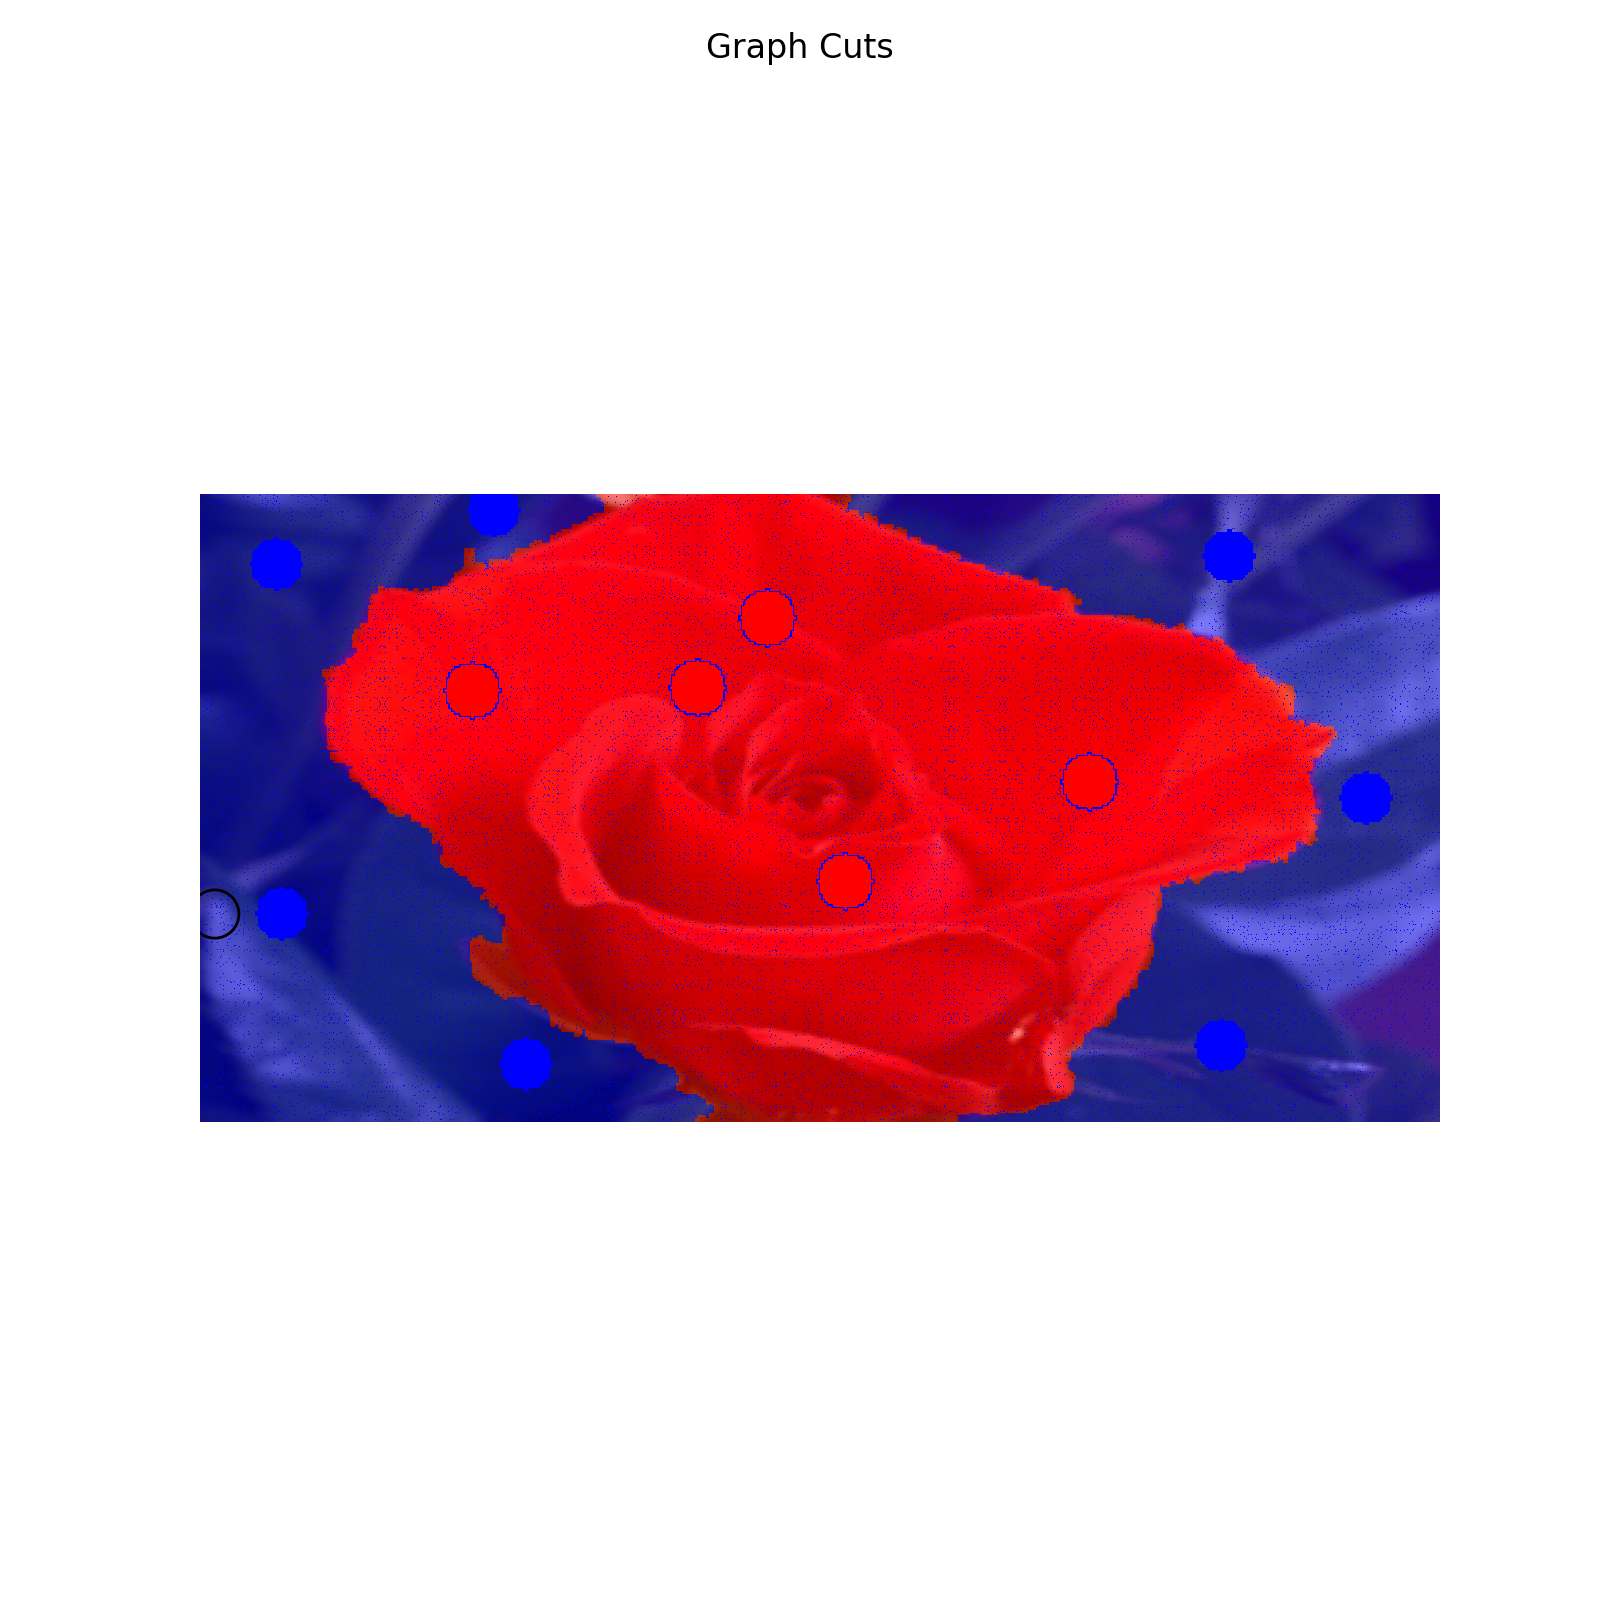

In [37]:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], 1, 5)
app.run()

In [38]:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], 10, 5)
app.run()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


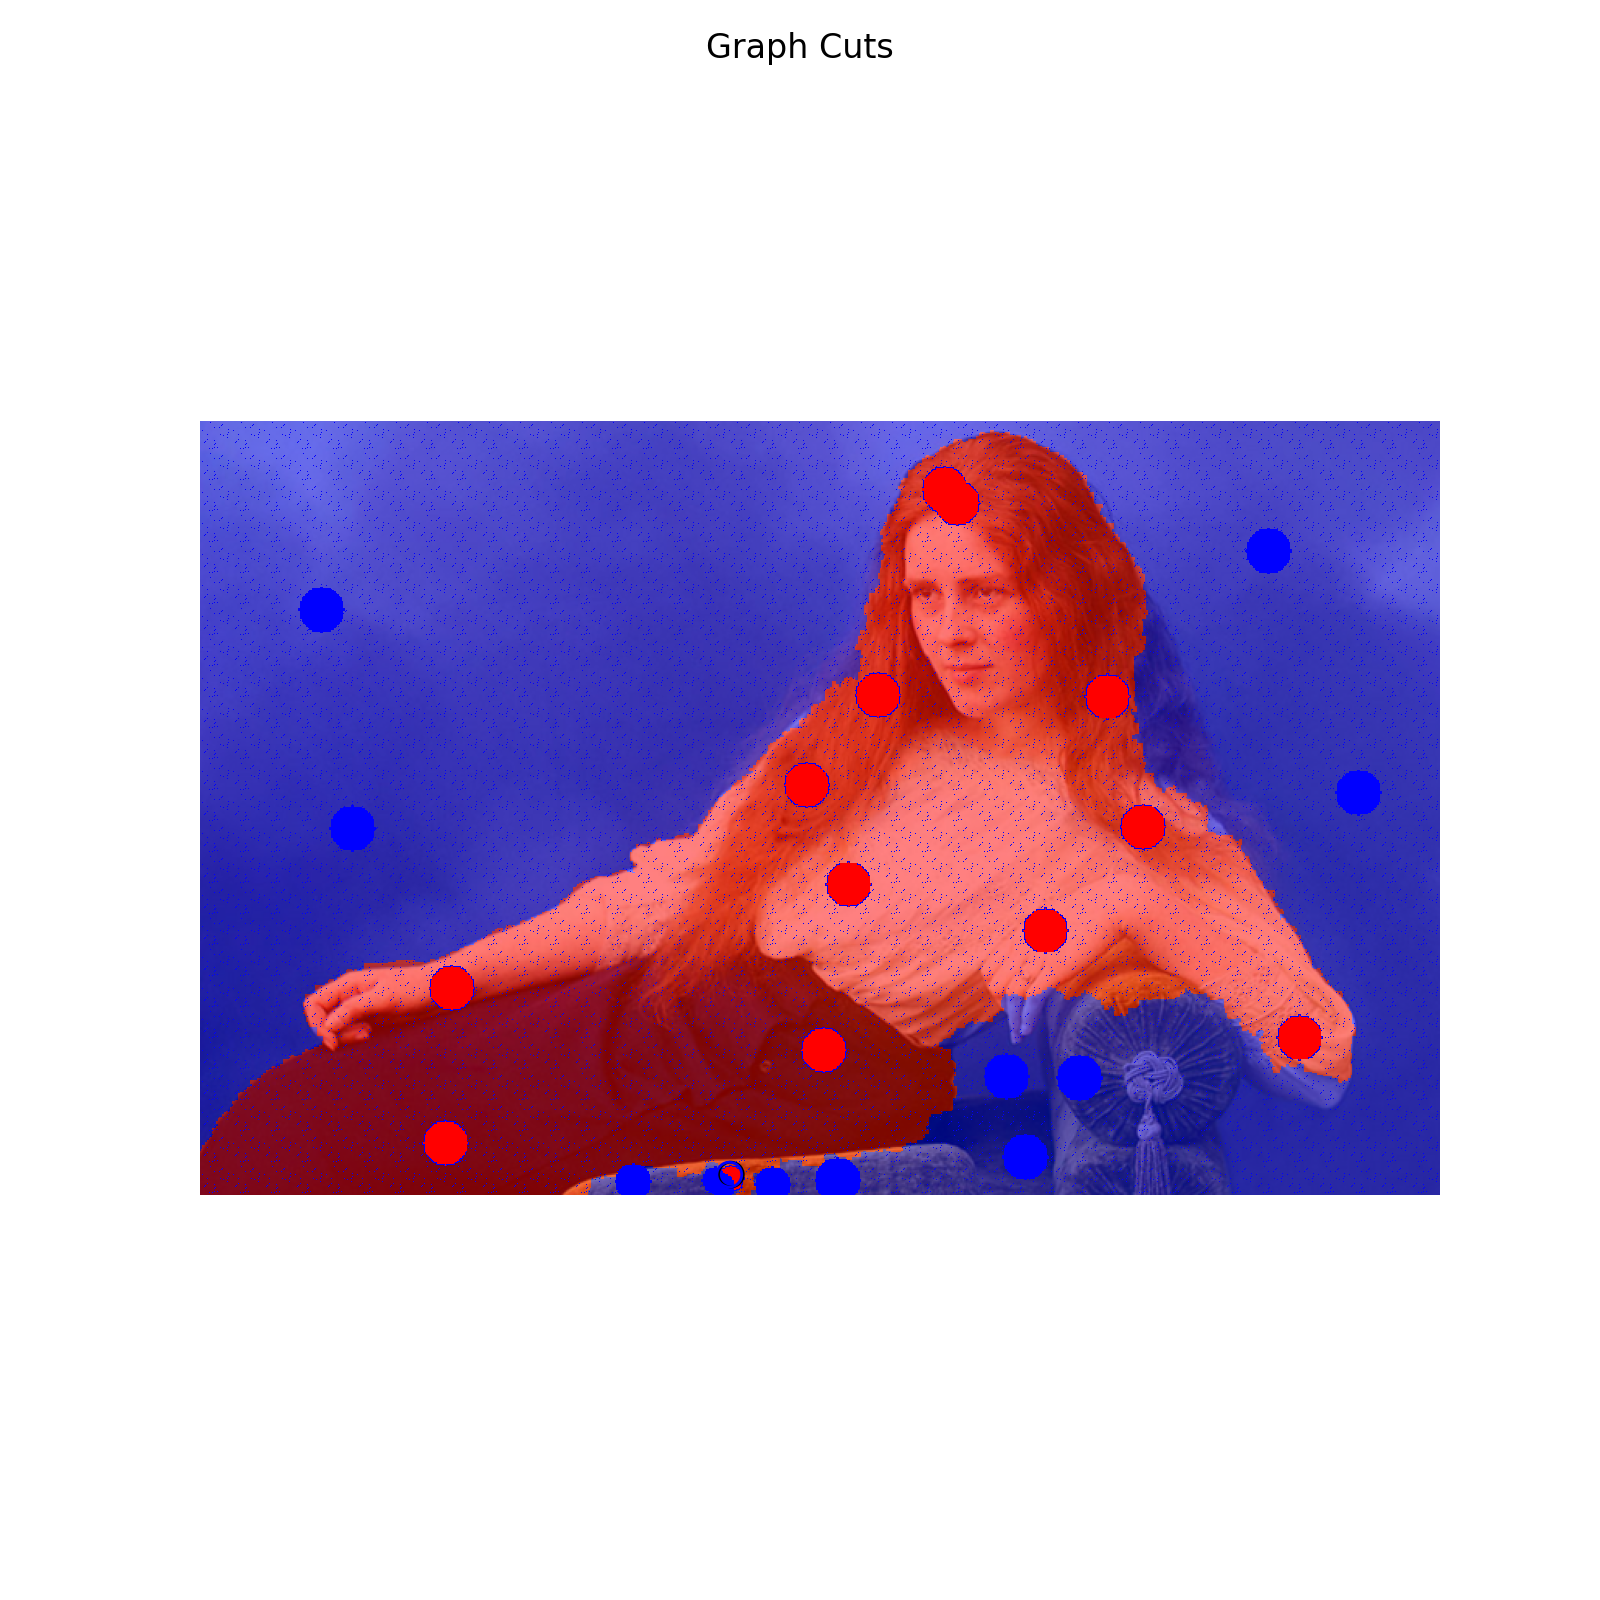

In [48]:
img = plt.imread('images/model.bmp')
app = MyGraphCuts(img[100:600,:800], 5, 5)
app.run()